<a href="https://colab.research.google.com/github/ChrisWbe/CursoML/blob/main/Eland_ML_ElasticCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install eland

     |████████████████████████████████| 122kB 4.3MB/s 
     |████████████████████████████████| 327kB 5.8MB/s 


In [1]:
#Conexion a ElasticSearch
ELASTIC_CLOUD_ID="eland-demo:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDI2ODUwMzAzNWRjYTQ5ZDdiM2NmNzdlYzNmNTVhZmI5JDdlYTZiY2UyZWVmZjQ1MTk5YzdiMzNlNDEzZTZhN2Q0"
ELASTIC_CLUD_PASS="kDf3NZUfvmlq46TyNgrfaxvC"

In [8]:
def json(x):
  import json
  print(json.dumps(x,indent=2,sort_keys=True))

In [50]:
import eland as ed
import pandas as pd
from elasticsearch import Elasticsearch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from math import sqrt

In [9]:
#Conexion a la instancia de elastic cloud
es = Elasticsearch(
    cloud_id=ELASTIC_CLOUD_ID,
    http_auth=('elastic',ELASTIC_CLUD_PASS)
)
json(es.info())

{
  "cluster_name": "268503035dca49d7b3cf77ec3f55afb9",
  "cluster_uuid": "gW23ez7WS8eLXVd6QbFVPA",
  "name": "instance-0000000000",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-12-05T01:00:33.671820Z",
    "build_flavor": "default",
    "build_hash": "1c34507e66d7db1211f66f3513706fdf548736aa",
    "build_snapshot": false,
    "build_type": "docker",
    "lucene_version": "8.7.0",
    "minimum_index_compatibility_version": "6.0.0-beta1",
    "minimum_wire_compatibility_version": "6.8.0",
    "number": "7.10.1"
  }
}


In [11]:
#Cargo datos para train y test (Datos de viviendas de viviendas de california Censo de 1990) 
#https://developers.google.com/machine-learning/crash-course/california-housing-data-description
pd_df_train = pd.read_csv("/content/sample_data/california_housing_train.csv")
pd_df_test = pd.read_csv("/content/sample_data/california_housing_test.csv")
print(pd_df_train.shape)
print(pd_df_test.shape)


(17000, 9)
(3000, 9)


In [12]:
pd_df_train.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [13]:
#Remuevo posibles valores nulos
pd_df_train = pd_df_train.dropna()
pd_df_test = pd_df_test.dropna()
print(pd_df_train.shape)
print(pd_df_test.shape)

(17000, 9)
(3000, 9)


<h1>Data Cleaning</h1>

In [14]:
#Combino latitud y longitud para dejar solo un campo de localización
pd_df_train['location'] = pd_df_train[['latitude','longitude']].apply(lambda x:",".join(str(item) for item in x), axis=1)
pd_df_test['location'] = pd_df_test[['latitude','longitude']].apply(lambda x:",".join(str(item) for item in x), axis=1)

#Elimino las columnas de latitud y longitud
del pd_df_train['latitude']
del pd_df_train['longitude']
del pd_df_test['latitude']
del pd_df_test['longitude']
pd_df_train.head(5)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,location
0,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0,"34.19,-114.31"
1,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0,"34.4,-114.47"
2,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0,"33.69,-114.56"
3,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,"33.64,-114.57"
4,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0,"33.57,-114.57"


<h1>DataFrame Eland</h1>

In [15]:
ed_df_train = ed.pandas_to_eland(
    pd_df=pd_df_train,
    es_client=es,
    es_dest_index="california_housing_train", #Nombre indice
    es_type_overrides={                       #Restringir tipo de columna
        "location":"geo_point"
    },
    es_if_exists="replace",                   #Reemplaza el dataset si ya existe el mismo index
    es_refresh=True                           #Espera a que los datos se indexen
)

ed_df_test = ed.pandas_to_eland(
    pd_df=pd_df_test,
    es_client=es,
    es_dest_index="california_housing_test",
    es_type_overrides={
        "location":"geo_point"
    },
    es_if_exists="replace",
    es_refresh=True
)
ed_df_train.info()

<class 'eland.dataframe.DataFrame'>
Index: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   households          17000 non-null  float64
 1   housing_median_age  17000 non-null  float64
 2   location            17000 non-null  object 
 3   median_house_value  17000 non-null  float64
 4   median_income       17000 non-null  float64
 5   population          17000 non-null  float64
 6   total_bedrooms      17000 non-null  float64
 7   total_rooms         17000 non-null  float64
dtypes: float64(7), object(1)
memory usage: 80.000 bytes
Elasticsearch storage usage: 5.476 MB


In [16]:
ed_df_train.head(5)

,households,housing_median_age,location,median_house_value,median_income,population,total_bedrooms,total_rooms
0,472.0,15.0,"34.19,-114.31",66900.0,1.4936,1015.0,1283.0,5612.0
1,463.0,19.0,"34.4,-114.47",80100.0,1.8200,1129.0,1901.0,7650.0
2,117.0,17.0,"33.69,-114.56",85700.0,1.6509,333.0,174.0,720.0
3,226.0,14.0,"33.64,-114.57",73400.0,3.1917,515.0,337.0,1501.0
4,262.0,20.0,"33.57,-114.57",65500.0,1.9250,624.0,326.0,1454.0


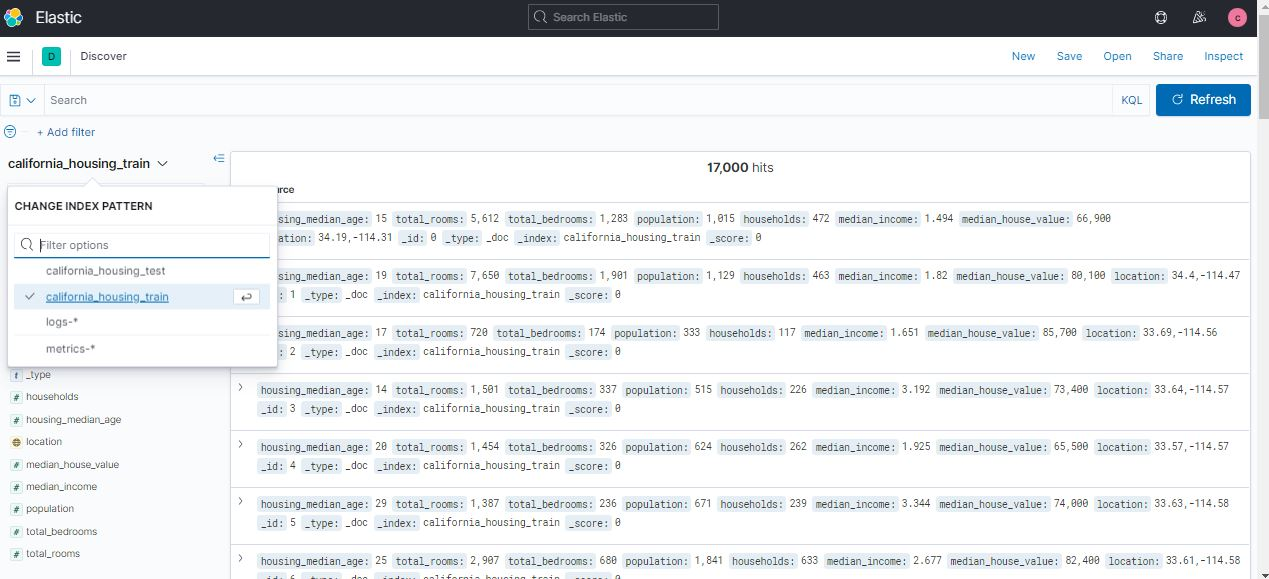

<h1>ML Processing</h1>

In [94]:
#Para este ejemplo se predente predecir medianHouseValue (Valor medio de la vivienda para hogares dentro de un bloque - medido en dolares), basado en los demás features o caracteristicas
#Localmente
features = ['median_income','population'] #Se escogen estas caracteristicas dado que puden tener relación en el valor de la vivienda
target = ['median_house_value']
x = pd_df_test[features]
y = pd_df_test[target]
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [95]:
x.head()

,median_income,population
0,6.6085,1537.0
1,3.5990,809.0
2,5.7934,1484.0
3,6.1359,49.0
4,2.9375,850.0


In [96]:
y.head()

,median_house_value
0,344700.0
1,176500.0
2,270500.0
3,330000.0
4,81700.0


In [97]:
#Intancia del modelo de regresión lineal
regressor = LinearRegression()

In [98]:
#Ajustando el modelo
regressor.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
x_test = pd_df_test[features]
y_test = pd_df_test[target]
y_test.shape

(3000, 1)

In [102]:
y_prediction = regressor.predict(x_test)
y_result = y_prediction - y_test
y_prediction.shape

(3000, 1)

In [103]:
RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction))
regressor.score(x_test,y_test) #precisión del modelo, en este caso del 54%

0.4530465082465729

In [104]:
print(RMSE)

83645.19572060955


In [105]:
regressor.coef_

array([[ 4.10777684e+04, -2.52295324e+00]])